In [1]:
import math
from typing import Tuple
import numpy as np
import pandas as pd


def load_students_csv() -> pd.DataFrame:
    candidates = [
        "../datasets/students_simple.csv",
    ]
    last_err = None
    for path in candidates:
        try:
            df = pd.read_csv(path)
            return df
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Не удалось загрузить CSV. Последняя ошибка: {last_err}")


df_raw = load_students_csv()

df = df_raw.select_dtypes(include=[np.number]).copy()

N = 1
idx1 = N % 5
idx2 = (N * N) % 5 + 5

col_x = df.columns[idx1]
col_y = df.columns[idx2]

x = df[col_x].astype(float).to_numpy()
y = df[col_y].astype(float).to_numpy()

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]


print(f"Выбраны столбцы по формулам при N={N}:")
print(f"  X := df['{col_x}']")
print(f"  Y := df['{col_y}']")
print(f"Размер выборки: n = {x.size}\n")
print(x)
print(y)

Выбраны столбцы по формулам при N=1:
  X := df['mass']
  Y := df['bmi']
Размер выборки: n = 20

[45. 61. 56. 48. 54. 58. 51. 62. 70. 72. 73. 64. 73. 68. 81. 84. 76. 90.
 68. 95.]
[3.533 2.623 2.875 3.375 3.    2.828 3.255 2.726 2.429 2.361 2.342 2.672
 2.356 2.559 2.173 2.095 2.342 2.011 2.691 2.021]


In [2]:
# --- 3) Коэф. Фехнера ---
# r_F = (A - B) / (A + B), где:
#   A — число наблюдений, у которых (x - mean_x) и (y - mean_y) одного знака,
#   B — числа наблюдений с противоположными знаками;
def fechner_corr(x: np.ndarray, y: np.ndarray) -> float:
    mx, my = np.mean(x), np.mean(y)
    sx = np.sign(x - mx)
    sy = np.sign(y - my)
    mask = (sx != 0) & (sy != 0)
    if not np.any(mask):
        return np.nan
    sx, sy = sx[mask], sy[mask]
    A = np.sum(sx == sy)
    B = np.sum(sx != sy)
    if (A + B) == 0:
        return np.nan
    return (A - B) / (A + B)

r_fechner = fechner_corr(x, y)



# --- 4) Пирсон + 95% доверительный интервал
def pearson_corr_ci(x: np.ndarray, y: np.ndarray) -> Tuple[float, float, float]:
    r = float(np.corrcoef(x, y)[0,1])
    n = x.size
    z = 0.5 * math.log((1 + r) / (1 - r))
    se = 1.0 / math.sqrt(n - 3)
    z_crit = 1.96
    z_lo = z - z_crit * se
    z_hi = z + z_crit * se
    lo = math.tanh(z_lo)
    hi = math.tanh(z_hi)
    return r, lo, hi

r_pearson, r_pearson_lo, r_pearson_hi = pearson_corr_ci(x, y)

# --- 5) Спирмен
def rankdata(a: np.ndarray) -> np.ndarray:
    s = pd.Series(a)
    return s.rank().to_numpy()

rx = rankdata(x)
ry = rankdata(y)
r_spearman = float(np.corrcoef(rx, ry)[0,1])

# --- 6) Кенделл
def kendall(x: np.ndarray, y: np.ndarray) -> float:
    n = x.size
    concordant = 0
    discordant = 0
    ties_x = 0
    ties_y = 0
    for i in range(n-1):
        dx = x[i+1:] - x[i]
        dy = y[i+1:] - y[i]
        sx = np.sign(dx)
        sy = np.sign(dy)
        ties_x += np.sum(sx == 0)
        ties_y += np.sum(sy == 0)
        mask = (sx != 0) & (sy != 0)
        sxy = sx[mask] * sy[mask]
        concordant += np.sum(sxy > 0)
        discordant += np.sum(sxy < 0)

    n_pairs = n * (n - 1) // 2
    t_x = ties_x
    t_y = ties_y
    denom = math.sqrt((n_pairs - t_x) * (n_pairs - t_y))
    if denom == 0:
        return np.nan
    return (concordant - discordant) / denom

r_kendall = kendall(x, y)

print("=== Корреляции по выбранным столбцам ===")
print(f"Фехнера (по знакам отклонений от среднего, игнорируя нули): r_F = {r_fechner: .6f}")
print(f"Пирсона: r = {r_pearson: .6f} | 95% ДИ: [{r_pearson_lo: .6f}; {r_pearson_hi: .6f}]")
print(f"Спирмена: ρ_s = {r_spearman: .6f}")
print(f"Кенделла: τ = {r_kendall: .6f}")

summary = pd.DataFrame({
    "Metric": ["Fechner", "Pearson", "Pearson 95% CI low", "Pearson 95% CI high", "Spearman", "Kendall"],
    "Value": [r_fechner, r_pearson, r_pearson_lo, r_pearson_hi, r_spearman, r_kendall]
})
print("\nСводка:")
display(summary)


=== Корреляции по выбранным столбцам ===
Фехнера (по знакам отклонений от среднего, игнорируя нули): r_F = -0.900000
Пирсона: r = -0.960609 | 95% ДИ: [-0.984591; -0.901163]
Спирмена: ρ_s = -0.984945
Кенделла (τ-b): τ = -0.938995

Сводка:


,Metric,Value
0,Fechner,-0.900000
1,Pearson,-0.960609
2,Pearson 95% CI low,-0.984591
3,Pearson 95% CI high,-0.901163
4,Spearman,-0.984945
5,Kendall (tau-b),-0.938995


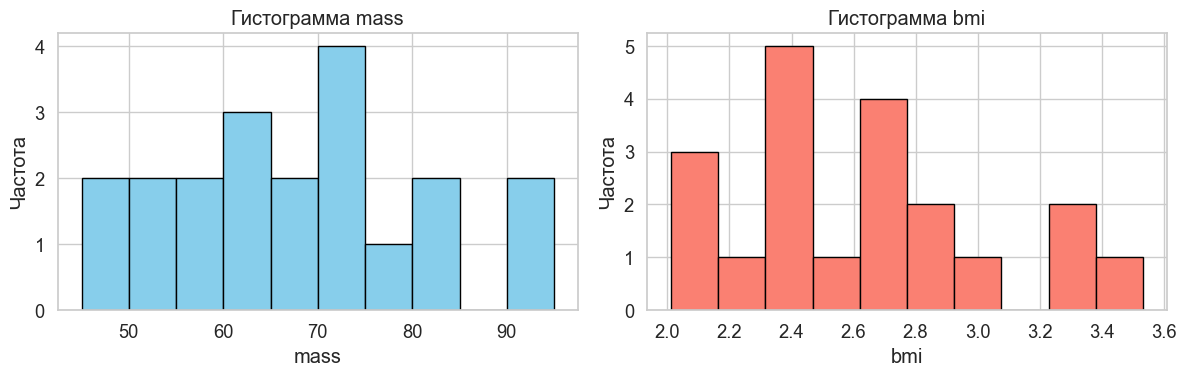

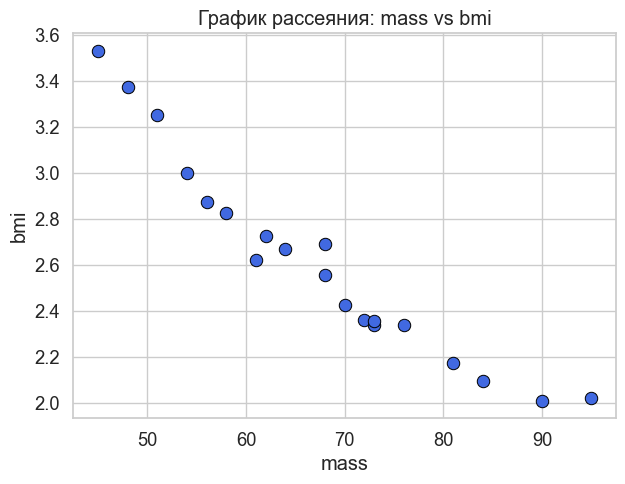

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.ravel()

axes[0].hist(x, bins=10, color="skyblue", edgecolor="black")
axes[0].set_title(f"Гистограмма {col_x}")
axes[0].set_xlabel(col_x)
axes[0].set_ylabel("Частота")

axes[1].hist(y, bins=10, color="salmon", edgecolor="black")
axes[1].set_title(f"Гистограмма {col_y}")
axes[1].set_xlabel(col_y)
axes[1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(x=x, y=y, color="royalblue", s=80, edgecolor="black")
plt.title(f"График рассеяния: {col_x} vs {col_y}")
plt.xlabel(col_x)
plt.ylabel(col_y)

plt.show()


,Модель,Уравнение,R²
0,Линейная,y = -0.0308x + 4.6881,0.922771
1,Квадратичная,y = 0.000493x² + -0.0990x + 6.9596,0.977930
2,Гиперболическая,y = 135.2427/x + 0.5275,0.979133
3,Показательная,y = 5.6857 * (0.9884)^x,0.954239


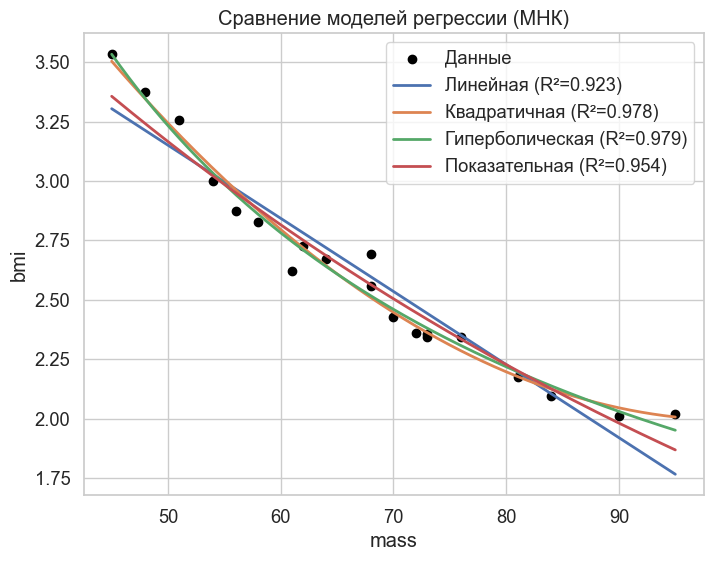

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot

# --- 1) Линейная регрессия ---
x_mean = np.mean(x)
y_mean = np.mean(y)

numerator = np.sum((x - x_mean) * (y - y_mean))
denominator = np.sum((x - x_mean)**2)
w1_lin = numerator / denominator
w0_lin = y_mean - w1_lin * x_mean
y_lin = w1_lin * x + w0_lin
r2_lin = r2_score(y, y_lin)

# --- 2) Квадратичная ---
X_quad = np.vstack([x**2, x, np.ones_like(x)]).T
w2_quad, w1_quad, w0_quad = np.linalg.lstsq(X_quad, y, rcond=None)[0]
y_quad = w2_quad * x**2 + w1_quad * x + w0_quad
r2_quad = r2_score(y, y_quad)

# --- 3) Гиперболическая (y = w1/x + w0) ---
# => линейная форма: y = w1*(1/x) + w0
X_hyp = np.vstack([1/x, np.ones_like(x)]).T
w1_hyp, w0_hyp = np.linalg.lstsq(X_hyp, y, rcond=None)[0]
y_hyp = w1_hyp / x + w0_hyp
r2_hyp = r2_score(y, y_hyp)

# --- 4) Показательная (y = w0 * w1^x)
# => ln(y) = ln(w0) + x*ln(w1)
mask = y > 0
X_exp = np.vstack([x[mask], np.ones_like(x[mask])]).T
ln_y = np.log(y[mask])
b_exp, a_exp = np.linalg.lstsq(X_exp, ln_y, rcond=None)[0]
# => ln(y) = a_exp + b_exp * x  => w0 = exp(a_exp), w1 = exp(b_exp)
w1_exp = np.exp(b_exp)
w0_exp = np.exp(a_exp)
y_exp = w0_exp * (w1_exp ** x)
r2_exp = r2_score(y, y_exp)

# --- Вывод результатов ---
results = pd.DataFrame([
    ["Линейная", f"y = {w1_lin:.4f}x + {w0_lin:.4f}", r2_lin],
    ["Квадратичная", f"y = {w2_quad:.6f}x² + {w1_quad:.4f}x + {w0_quad:.4f}", r2_quad],
    ["Гиперболическая", f"y = {w1_hyp:.4f}/x + {w0_hyp:.4f}", r2_hyp],
    ["Показательная", f"y = {w0_exp:.4f} * ({w1_exp:.4f})^x", r2_exp],
], columns=["Модель", "Уравнение", "R²"])
display(results)

plt.figure(figsize=(8,6))
plt.scatter(x, y, color="black", label="Данные")

x_line = np.linspace(min(x), max(x), 200)
plt.plot(x_line, w1_lin*x_line + w0_lin, label=f"Линейная (R²={r2_lin:.3f})", lw=2)
plt.plot(x_line, w2_quad*x_line**2 + w1_quad*x_line + w0_quad, label=f"Квадратичная (R²={r2_quad:.3f})", lw=2)
plt.plot(x_line, w1_hyp/x_line + w0_hyp, label=f"Гиперболическая (R²={r2_hyp:.3f})", lw=2)
plt.plot(x_line, w0_exp * (w1_exp ** x_line), label=f"Показательная (R²={r2_exp:.3f})", lw=2)

plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title("Сравнение моделей регрессии (МНК)")
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from scipy.stats import f

models_data = [
    ("Линейная", y_lin, 2),
    ("Квадратичная", y_quad, 3),
    ("Гиперболическая", y_hyp, 2),
    ("Показательная", y_exp, 2)
]
r2_values = [r2_lin, r2_quad, r2_hyp, r2_exp]
model_names = [m[0] for m in models_data]

best_idx = int(np.argmax(r2_values))
worst_idx = int(np.argmin(r2_values))

best_name, y_best, p_best = models_data[best_idx]
worst_name, y_worst, p_worst = models_data[worst_idx]

def fisher_test(y_true, y_pred, p, alpha=0.05):
    """
    Расчет критерия Фишера для регрессионной модели.
    F = (R^2 / (p - 1)) / ((1 - R^2) / (n - p))
    """
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    F_calc = (r2 / (p - 1)) / ((1 - r2) / (n - p))
    F_crit = f.ppf(1 - alpha, p - 1, n - p)
    significant = F_calc > F_crit
    return F_calc, F_crit, significant

F_best, Fcrit_best, sig_best = fisher_test(y, y_best, p_best)
F_worst, Fcrit_worst, sig_worst = fisher_test(y, y_worst, p_worst)

print("=== Проверка моделей по критерию Фишера (α = 0.05) ===\n")
print(f"Лучшая модель: {best_name}")
print(f"  F_расч = {F_best:.3f},  F_кр = {Fcrit_best:.3f}")
print(f"  => {'Модель статистически значима' if sig_best else 'Модель незначима'}\n")

print(f"Худшая модель: {worst_name}")
print(f"  F_расч = {F_worst:.3f},  F_кр = {Fcrit_worst:.3f}")
print(f"  => {'Модель статистически значима' if sig_worst else 'Модель незначима'}")


=== Проверка моделей по критерию Фишера (α = 0.05) ===

Лучшая модель: Гиперболическая
  F_расч = 844.595,  F_кр = 4.414
  => Модель статистически значима

Худшая модель: Линейная
  F_расч = 215.072,  F_кр = 4.414
  => Модель статистически значима
